In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from alibi.explainers import PartialDependence, plot_pd

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df = df.drop('dteday', axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,temp,atemp,hum,windspeed,casual,registered,cnt,workday,weather,days_since_2011,cnt_2d_bfr
0,3,WINTER,2011,JAN,N,MON,1.229108,22.439770,43.7273,16.636703,120,1229,1349,Y,GOOD,2,985
1,4,WINTER,2011,JAN,N,TUE,1.400000,23.212148,59.0435,10.739832,108,1454,1562,Y,GOOD,3,801
2,5,WINTER,2011,JAN,N,WED,2.666979,23.795180,43.6957,12.522300,82,1518,1600,Y,GOOD,4,1349
3,6,WINTER,2011,JAN,N,THU,1.604356,23.929106,51.8261,6.000868,88,1518,1606,Y,GOOD,5,1562
4,7,WINTER,2011,JAN,N,FRI,1.236534,23.100526,49.8696,11.304642,148,1362,1510,Y,MISTY,6,1600


In [14]:
feature_names = df.columns.tolist()
feature_names.remove('cnt')

target_names = ['Number of Bikes']
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workday', 'weather']

categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(cn) for cn in feature_names if cn not in categorical_columns_names]

X = df[feature_names]
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(categorical_columns_indices, numerical_columns_indices)

[1, 2, 3, 4, 5, 12, 13] [0, 6, 7, 8, 9, 10, 11, 14, 15]


In [15]:
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

categorical_names = {i:list(v) for i, v in zip(categorical_columns_indices, oe.categories_)}
categorical_names

{1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
 2: [2011, 2012],
 3: ['APR',
  'AUG',
  'DEC',
  'FEB',
  'JAN',
  'JUL',
  'JUN',
  'MAR',
  'MAY',
  'NOV',
  'OCT',
  'SEP'],
 4: ['N', 'Y'],
 5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
 12: ['N', 'Y'],
 13: ['BAD', 'GOOD', 'MISTY']}

In [16]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_columns_indices),
                                  ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns_indices)])
preprocessor.fit(X_train)
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [20]:
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
predictor.score(X_train_ohe, y_train), predictor.score(X_test_ohe, y_test)

(0.9993321626811753, 0.9937793062444231)

In [22]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [23]:
explainer = PartialDependence(predictor=prediction_fn, feature_names=feature_names, target_names=target_names, categorical_names=categorical_names)

In [24]:
features = [feature_names.index('temp'), feature_names.index('hum'), feature_names.index('windspeed'), feature_names.index('season')]
features

[6, 8, 9, 1]

In [25]:
exp = explainer.explain(X=X_train, features=None, kind='average')
exp

Explanation(meta={
  'name': 'PartialDependence',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'kind': 'average',
              'percentiles': (0.0, 1.0),
              'grid_resolution': 100,
              'feature_names': ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'workday', 'weather', 'days_since_2011', 'cnt_2d_bfr'],
              'categorical_names': {
                                     1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
                                     2: [2011, 2012],
                                     3: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'],
                                     4: ['N', 'Y'],
                                     5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
                                     12: ['N', 'Y'],
                                     13: ['BAD', 'GOOD', 'MISTY']}
    

array([[<AxesSubplot:xlabel='instant', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='season', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='yr', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='mnth', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='holiday', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='weekday', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='temp', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='atemp', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='hum', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='windspeed', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='casual', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='registered', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='workday', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='weather', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='days_since_2011', ylabel='Number of Bikes'>],
       [<Ax

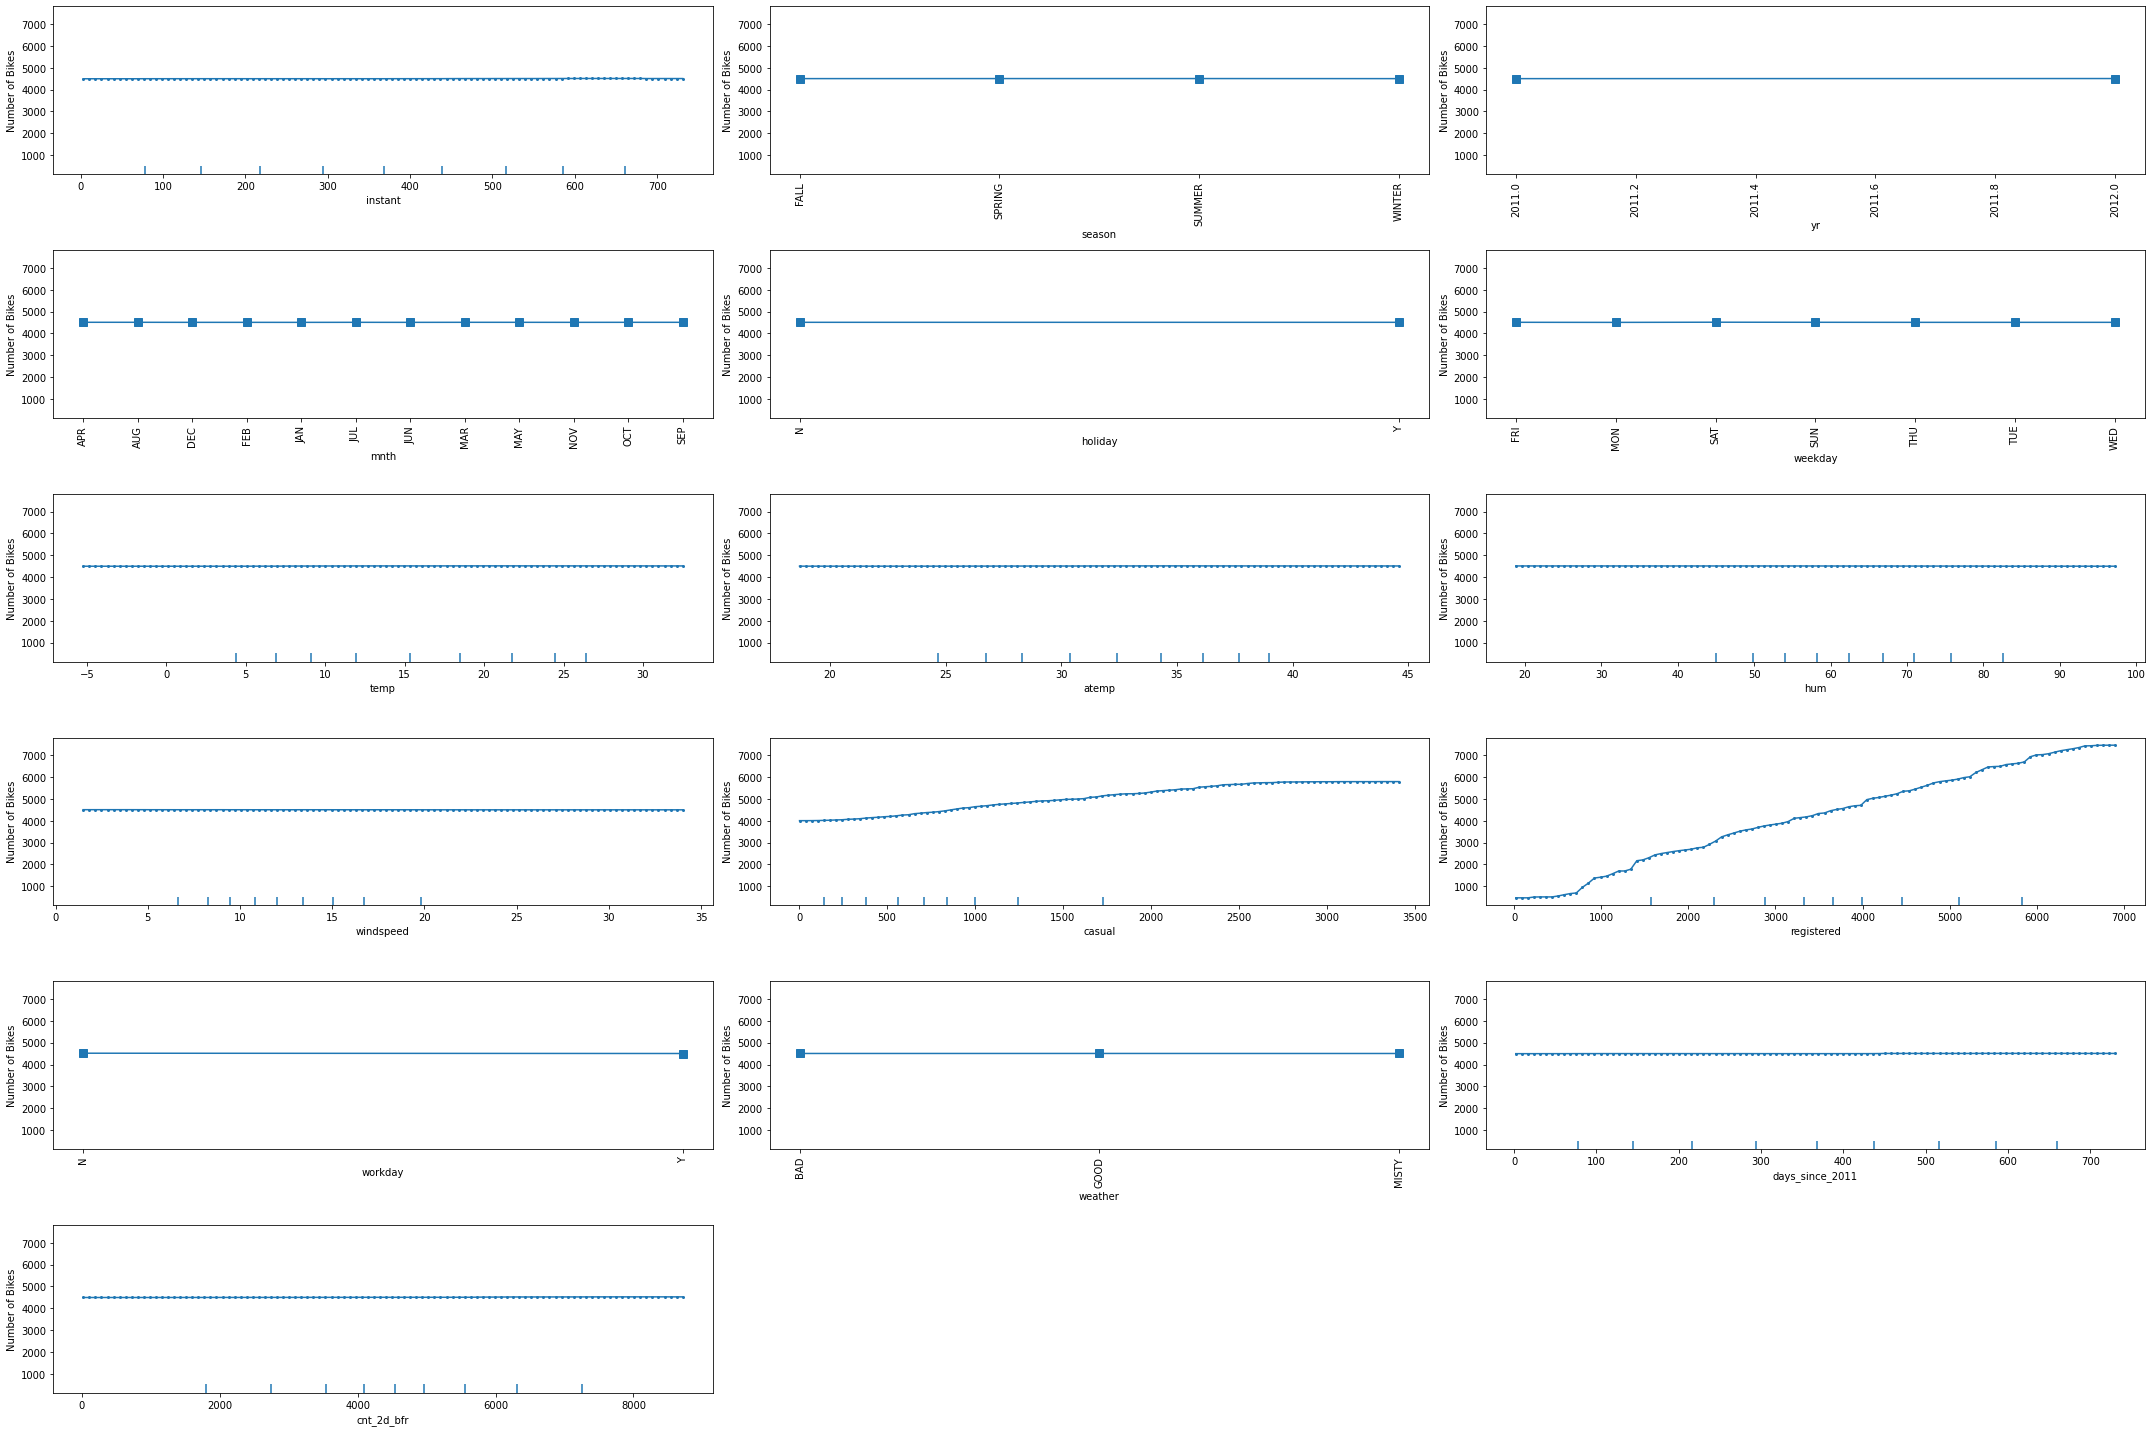

In [28]:
plot_pd(exp=exp, fig_kw={'figheight':20, 'figwidth':30})

In [29]:
feature_interaction = [(feature_names.index('temp'), feature_names.index('windspeed')),
                       (feature_names.index('mnth'), feature_names.index('weather'))]

In [30]:
exp_int = explainer.explain(X=X_train, features=feature_interaction, kind='average')

array([[<AxesSubplot:xlabel='temp', ylabel='windspeed'>,
        <AxesSubplot:xlabel='weather', ylabel='mnth'>]], dtype=object)

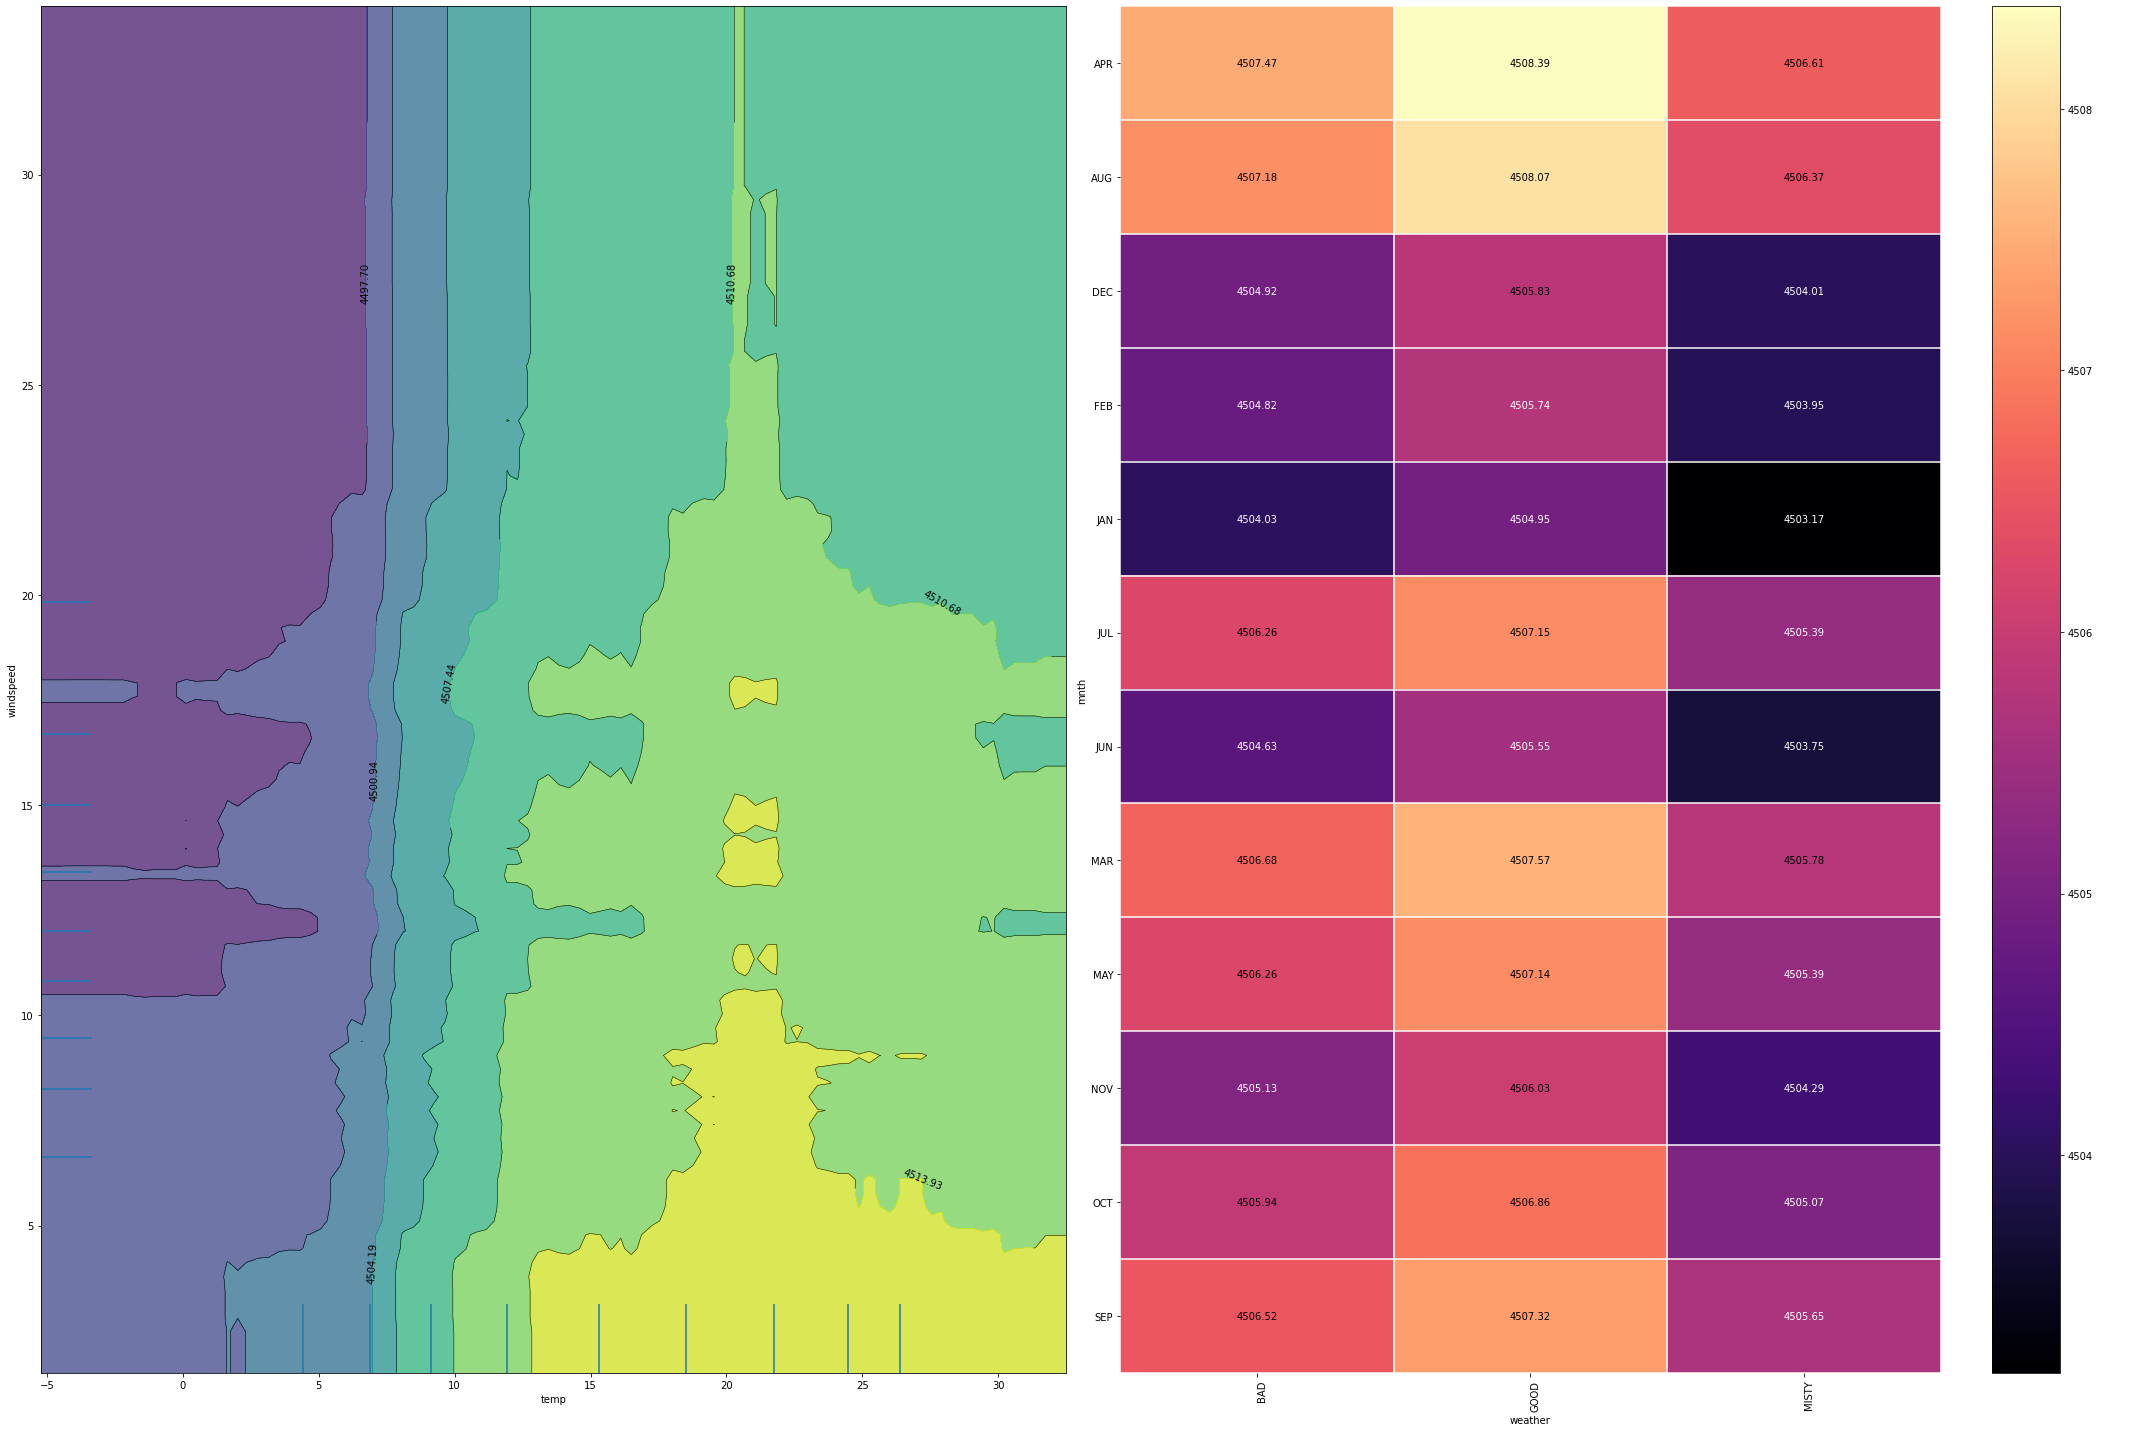

In [31]:
plot_pd(exp=exp_int, fig_kw={'figheight':20, 'figwidth':30})